In this notebook, we analyze the BACE enyzme and build machine learning models for predicting the Ki of ligands to the protein. We will use the `deepchem` library to load this data into memory, split into train/test/validation folds, build and cross-validate models, and report statistics.

In [1]:
%load_ext autoreload
%autoreload 2
%pdb off
import sys
# This will be removed
sys.path.append('/home/rbharath/deepchem/')
import deepchem
from deepchem.utils.save import load_from_disk

dataset_file= "../datasets/desc_canvas_aug30.csv"
dataset = load_from_disk(dataset_file)
num_display=10
pretty_columns = (
    "[" + ",".join(["'%s'" % column for column in dataset.columns.values[:num_display]])
    + ",...]")
print("Columns of dataset: %s" % pretty_columns)
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

Automatic pdb calling has been turned OFF
Columns of dataset: ['mol','CID','Class','Model','pIC50','MW','AlogP','HBA','HBD','RB',...]
Number of examples in dataset: 1522


To gain a visual understanding of compounds in our dataset, let's draw them using rdkit. We define a couple of helper functions to get started.

In [2]:
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display, HTML

def display_images(filenames):
    """Helper to pretty-print images."""
    imagesList=''.join(
        ["<img style='width: 140px; margin: 0px; float: left; border: 1px solid black;' src='%s' />"
         % str(s) for s in sorted(filenames)])
    display(HTML(imagesList))    

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

Now, we display a compound from the dataset. Note the complex ring structures and polar structures.

In [3]:
num_to_display = 12
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["mol"]))
display_images(mols_to_pngs(molecules))

Analyzing the distribution of pIC50 values in the dataset gives us a nice spread.

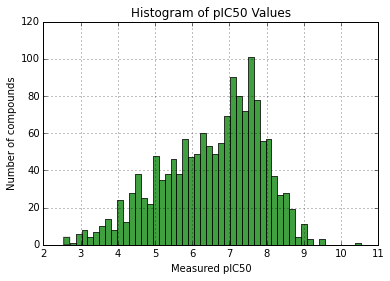

In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

pIC50s = np.array(dataset["pIC50"])
# Remove some dirty data from the dataset
pIC50s = [pIC50 for pIC50 in pIC50s if pIC50 != '']
n, bins, patches = plt.hist(pIC50s, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured pIC50')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of pIC50 Values')
plt.grid(True)
plt.show()

We now featurize the data using the Canvas samples. To do so, we must specify the columns in the data input that correspond to the features. (Note that CanvasUID is excluded!)

In [5]:
user_specified_features = ['MW','AlogP','HBA','HBD','RB','HeavyAtomCount','ChiralCenterCount','ChiralCenterCountAllPossible','RingCount','PSA','Estate','MR','Polar','sLi_Key','ssBe_Key','ssssBem_Key','sBH2_Key','ssBH_Key','sssB_Key','ssssBm_Key','sCH3_Key','dCH2_Key','ssCH2_Key','tCH_Key','dsCH_Key','aaCH_Key','sssCH_Key','ddC_Key','tsC_Key','dssC_Key','aasC_Key','aaaC_Key','ssssC_Key','sNH3_Key','sNH2_Key','ssNH2_Key','dNH_Key','ssNH_Key','aaNH_Key','tN_Key','sssNH_Key','dsN_Key','aaN_Key','sssN_Key','ddsN_Key','aasN_Key','ssssN_Key','daaN_Key','sOH_Key','dO_Key','ssO_Key','aaO_Key','aOm_Key','sOm_Key','sF_Key','sSiH3_Key','ssSiH2_Key','sssSiH_Key','ssssSi_Key','sPH2_Key','ssPH_Key','sssP_Key','dsssP_Key','ddsP_Key','sssssP_Key','sSH_Key','dS_Key','ssS_Key','aaS_Key','dssS_Key','ddssS_Key','ssssssS_Key','Sm_Key','sCl_Key','sGeH3_Key','ssGeH2_Key','sssGeH_Key','ssssGe_Key','sAsH2_Key','ssAsH_Key','sssAs_Key','dsssAs_Key','ddsAs_Key','sssssAs_Key','sSeH_Key','dSe_Key','ssSe_Key','aaSe_Key','dssSe_Key','ssssssSe_Key','ddssSe_Key','sBr_Key','sSnH3_Key','ssSnH2_Key','sssSnH_Key','ssssSn_Key','sI_Key','sPbH3_Key','ssPbH2_Key','sssPbH_Key','ssssPb_Key','sLi_Cnt','ssBe_Cnt','ssssBem_Cnt','sBH2_Cnt','ssBH_Cnt','sssB_Cnt','ssssBm_Cnt','sCH3_Cnt','dCH2_Cnt','ssCH2_Cnt','tCH_Cnt','dsCH_Cnt','aaCH_Cnt','sssCH_Cnt','ddC_Cnt','tsC_Cnt','dssC_Cnt','aasC_Cnt','aaaC_Cnt','ssssC_Cnt','sNH3_Cnt','sNH2_Cnt','ssNH2_Cnt','dNH_Cnt','ssNH_Cnt','aaNH_Cnt','tN_Cnt','sssNH_Cnt','dsN_Cnt','aaN_Cnt','sssN_Cnt','ddsN_Cnt','aasN_Cnt','ssssN_Cnt','daaN_Cnt','sOH_Cnt','dO_Cnt','ssO_Cnt','aaO_Cnt','aOm_Cnt','sOm_Cnt','sF_Cnt','sSiH3_Cnt','ssSiH2_Cnt','sssSiH_Cnt','ssssSi_Cnt','sPH2_Cnt','ssPH_Cnt','sssP_Cnt','dsssP_Cnt','ddsP_Cnt','sssssP_Cnt','sSH_Cnt','dS_Cnt','ssS_Cnt','aaS_Cnt','dssS_Cnt','ddssS_Cnt','ssssssS_Cnt','Sm_Cnt','sCl_Cnt','sGeH3_Cnt','ssGeH2_Cnt','sssGeH_Cnt','ssssGe_Cnt','sAsH2_Cnt','ssAsH_Cnt','sssAs_Cnt','dsssAs_Cnt','ddsAs_Cnt','sssssAs_Cnt','sSeH_Cnt','dSe_Cnt','ssSe_Cnt','aaSe_Cnt','dssSe_Cnt','ssssssSe_Cnt','ddssSe_Cnt','sBr_Cnt','sSnH3_Cnt','ssSnH2_Cnt','sssSnH_Cnt','ssssSn_Cnt','sI_Cnt','sPbH3_Cnt','ssPbH2_Cnt','sssPbH_Cnt','ssssPb_Cnt','sLi_Sum','ssBe_Sum','ssssBem_Sum','sBH2_Sum','ssBH_Sum','sssB_Sum','ssssBm_Sum','sCH3_Sum','dCH2_Sum','ssCH2_Sum','tCH_Sum','dsCH_Sum','aaCH_Sum','sssCH_Sum','ddC_Sum','tsC_Sum','dssC_Sum','aasC_Sum','aaaC_Sum','ssssC_Sum','sNH3_Sum','sNH2_Sum','ssNH2_Sum','dNH_Sum','ssNH_Sum','aaNH_Sum','tN_Sum','sssNH_Sum','dsN_Sum','aaN_Sum','sssN_Sum','ddsN_Sum','aasN_Sum','ssssN_Sum','daaN_Sum','sOH_Sum','dO_Sum','ssO_Sum','aaO_Sum','aOm_Sum','sOm_Sum','sF_Sum','sSiH3_Sum','ssSiH2_Sum','sssSiH_Sum','ssssSi_Sum','sPH2_Sum','ssPH_Sum','sssP_Sum','dsssP_Sum','ddsP_Sum','sssssP_Sum','sSH_Sum','dS_Sum','ssS_Sum','aaS_Sum','dssS_Sum','ddssS_Sum','ssssssS_Sum','Sm_Sum','sCl_Sum','sGeH3_Sum','ssGeH2_Sum','sssGeH_Sum','ssssGe_Sum','sAsH2_Sum','ssAsH_Sum','sssAs_Sum','dsssAs_Sum','ddsAs_Sum','sssssAs_Sum','sSeH_Sum','dSe_Sum','ssSe_Sum','aaSe_Sum','dssSe_Sum','ssssssSe_Sum','ddssSe_Sum','sBr_Sum','sSnH3_Sum','ssSnH2_Sum','sssSnH_Sum','ssssSn_Sum','sI_Sum','sPbH3_Sum','ssPbH2_Sum','sssPbH_Sum','ssssPb_Sum','sLi_Avg','ssBe_Avg','ssssBem_Avg','sBH2_Avg','ssBH_Avg','sssB_Avg','ssssBm_Avg','sCH3_Avg','dCH2_Avg','ssCH2_Avg','tCH_Avg','dsCH_Avg','aaCH_Avg','sssCH_Avg','ddC_Avg','tsC_Avg','dssC_Avg','aasC_Avg','aaaC_Avg','ssssC_Avg','sNH3_Avg','sNH2_Avg','ssNH2_Avg','dNH_Avg','ssNH_Avg','aaNH_Avg','tN_Avg','sssNH_Avg','dsN_Avg','aaN_Avg','sssN_Avg','ddsN_Avg','aasN_Avg','ssssN_Avg','daaN_Avg','sOH_Avg','dO_Avg','ssO_Avg','aaO_Avg','aOm_Avg','sOm_Avg','sF_Avg','sSiH3_Avg','ssSiH2_Avg','sssSiH_Avg','ssssSi_Avg','sPH2_Avg','ssPH_Avg','sssP_Avg','dsssP_Avg','ddsP_Avg','sssssP_Avg','sSH_Avg','dS_Avg','ssS_Avg','aaS_Avg','dssS_Avg','ddssS_Avg','ssssssS_Avg','Sm_Avg','sCl_Avg','sGeH3_Avg','ssGeH2_Avg','sssGeH_Avg','ssssGe_Avg','sAsH2_Avg','ssAsH_Avg','sssAs_Avg','dsssAs_Avg','ddsAs_Avg','sssssAs_Avg','sSeH_Avg','dSe_Avg','ssSe_Avg','aaSe_Avg','dssSe_Avg','ssssssSe_Avg','ddssSe_Avg','sBr_Avg','sSnH3_Avg','ssSnH2_Avg','sssSnH_Avg','ssssSn_Avg','sI_Avg','sPbH3_Avg','ssPbH2_Avg','sssPbH_Avg','ssssPb_Avg','First Zagreb (ZM1)','First Zagreb index by valence vertex degrees (ZM1V)','Second Zagreb (ZM2)','Second Zagreb index by valence vertex degrees (ZM2V)','Polarity (Pol)','Narumi Simple Topological (NST)','Narumi Harmonic Topological (NHT)','Narumi Geometric Topological (NGT)','Total structure connectivity (TSC)','Wiener (W)','Mean Wiener (MW)','Xu (Xu)','Quadratic (QIndex)','Radial centric (RC)','Mean Square Distance Balaban (MSDB)','Superpendentic (SP)','Harary (Har)','Log of product of row sums (LPRS)','Pogliani (Pog)','Schultz Molecular Topological (SMT)','Schultz Molecular Topological by valence vertex degrees (SMTV)','Mean Distance Degree Deviation (MDDD)','Ramification (Ram)','Gutman Molecular Topological (GMT)','Gutman MTI by valence vertex degrees (GMTV)','Average vertex distance degree (AVDD)','Unipolarity (UP)','Centralization (CENT)','Variation (VAR)','Molecular electrotopological variation (MEV)','Maximal electrotopological positive variation (MEPV)','Maximal electrotopological negative variation (MENV)','Eccentric connectivity (ECCc)','Eccentricity (ECC)','Average eccentricity (AECC)','Eccentric (DECC)','Valence connectivity index chi-0 (vX0)','Valence connectivity index chi-1 (vX1)','Valence connectivity index chi-2 (vX2)','Valence connectivity index chi-3 (vX3)','Valence connectivity index chi-4 (vX4)','Valence connectivity index chi-5 (vX5)','Average valence connectivity index chi-0 (AvX0)','Average valence connectivity index chi-1 (AvX1)','Average valence connectivity index chi-2 (AvX2)','Average valence connectivity index chi-3 (AvX3)','Average valence connectivity index chi-4 (AvX4)','Average valence connectivity index chi-5 (AvX5)','Quasi Wiener (QW)','First Mohar (FM)','Second Mohar (SM)','Spanning tree number (STN)','Kier benzene-likeliness index (KBLI)','Topological charge index of order 1 (TCI1)','Topological charge index of order 2 (TCI2)','Topological charge index of order 3 (TCI3)','Topological charge index of order 4 (TCI4)','Topological charge index of order 5 (TCI5)','Topological charge index of order 6 (TCI6)','Topological charge index of order 7 (TCI7)','Topological charge index of order 8 (TCI8)','Topological charge index of order 9 (TCI9)','Topological charge index of order 10 (TCI10)','Mean topological charge index of order 1 (MTCI1)','Mean topological charge index of order 2 (MTCI2)','Mean topological charge index of order 3 (MTCI3)','Mean topological charge index of order 4 (MTCI4)','Mean topological charge index of order 5 (MTCI5)','Mean topological charge index of order 6 (MTCI6)','Mean topological charge index of order 7 (MTCI7)','Mean topological charge index of order 8 (MTCI8)','Mean topological charge index of order 9 (MTCI9)','Mean topological charge index of order 10 (MTCI10)','Global topological charge (GTC)','Hyper-distance-path index (HDPI)','Reciprocal hyper-distance-path index (RHDPI)','Square reciprocal distance sum (SRDS)','Modified Randic connectivity (MRC)','Balaban centric (BC)','Lopping centric (LC)','Kier Hall electronegativity (KHE)','Sum of topological distances between N..N (STD(N N))','Sum of topological distances between N..O (STD(N O))','Sum of topological distances between N..S (STD(N S))','Sum of topological distances between N..P (STD(N P))','Sum of topological distances between N..F (STD(N F))','Sum of topological distances between N..Cl (STD(N Cl))','Sum of topological distances between N..Br (STD(N Br))','Sum of topological distances between N..I (STD(N I))','Sum of topological distances between O..O (STD(O O))','Sum of topological distances between O..S (STD(O S))','Sum of topological distances between O..P (STD(O P))','Sum of topological distances between O..F (STD(O F))','Sum of topological distances between O..Cl (STD(O Cl))','Sum of topological distances between O..Br (STD(O Br))','Sum of topological distances between O..I (STD(O I))','Sum of topological distances between S..S (STD(S S))','Sum of topological distances between S..P (STD(S P))','Sum of topological distances between S..F (STD(S F))','Sum of topological distances between S..Cl (STD(S Cl))','Sum of topological distances between S..Br (STD(S Br))','Sum of topological distances between S..I (STD(S I))','Sum of topological distances between P..P (STD(P P))','Sum of topological distances between P..F (STD(P F))','Sum of topological distances between P..Cl (STD(P Cl))','Sum of topological distances between P..Br (STD(P Br))','Sum of topological distances between P..I (STD(P I))','Sum of topological distances between F..F (STD(F F))','Sum of topological distances between F..Cl (STD(F Cl))','Sum of topological distances between F..Br (STD(F Br))','Sum of topological distances between F..I (STD(F I))','Sum of topological distances between Cl..Cl (STD(Cl Cl))','Sum of topological distances between Cl..Br (STD(Cl Br))','Sum of topological distances between Cl..I (STD(Cl I))','Sum of topological distances between Br..Br (STD(Br Br))','Sum of topological distances between Br..I (STD(Br I))','Sum of topological distances between I..I (STD(I I))','Wiener-type index from Z weighted distance matrix - Barysz matrix (WhetZ)','Wiener-type index from electronegativity weighted distance matrix (Whete)','Wiener-type index from mass weighted distance matrix (Whetm)','Wiener-type index from van der waals weighted distance matrix (Whetv)','Wiener-type index from polarizability weighted distance matrix (Whetp)','Balaban-type index from Z weighted distance matrix - Barysz matrix (JhetZ)','Balaban-type index from electronegativity weighted distance matrix (Jhete)','Balaban-type index from mass weighted distance matrix (Jhetm)','Balaban-type index from van der waals weighted distance matrix (Jhetv)','Balaban-type index from polarizability weighted distance matrix (Jhetp)','Topological diameter (TD)','Topological radius (TR)','Petitjean 2D shape (PJ2DS)','Balaban distance connectivity index (J)','Solvation connectivity index chi-0 (SCIX0)','Solvation connectivity index chi-1 (SCIX1)','Solvation connectivity index chi-2 (SCIX2)','Solvation connectivity index chi-3 (SCIX3)','Solvation connectivity index chi-4 (SCIX4)','Solvation connectivity index chi-5 (SCIX5)','Connectivity index chi-0 (CIX0)','Connectivity chi-1 [Randic connectivity] (CIX1)','Connectivity index chi-2 (CIX2)','Connectivity index chi-3 (CIX3)','Connectivity index chi-4 (CIX4)','Connectivity index chi-5 (CIX5)','Average connectivity index chi-0 (ACIX0)','Average connectivity index chi-1 (ACIX1)','Average connectivity index chi-2 (ACIX2)','Average connectivity index chi-3 (ACIX3)','Average connectivity index chi-4 (ACIX4)','Average connectivity index chi-5 (ACIX5)','reciprocal distance Randic-type index (RDR)','reciprocal distance square Randic-type index (RDSR)','1-path Kier alpha-modified shape index (KAMS1)','2-path Kier alpha-modified shape index (KAMS2)','3-path Kier alpha-modified shape index (KAMS3)','Kier flexibility (KF)','path/walk 2 - Randic shape index (RSIpw2)','path/walk 3 - Randic shape index (RSIpw3)','path/walk 4 - Randic shape index (RSIpw4)','path/walk 5 - Randic shape index (RSIpw5)','E-state topological parameter (ETP)','Ring Count 3 (RNGCNT3)','Ring Count 4 (RNGCNT4)','Ring Count 5 (RNGCNT5)','Ring Count 6 (RNGCNT6)','Ring Count 7 (RNGCNT7)','Ring Count 8 (RNGCNT8)','Ring Count 9 (RNGCNT9)','Ring Count 10 (RNGCNT10)','Ring Count 11 (RNGCNT11)','Ring Count 12 (RNGCNT12)','Ring Count 13 (RNGCNT13)','Ring Count 14 (RNGCNT14)','Ring Count 15 (RNGCNT15)','Ring Count 16 (RNGCNT16)','Ring Count 17 (RNGCNT17)','Ring Count 18 (RNGCNT18)','Ring Count 19 (RNGCNT19)','Ring Count 20 (RNGCNT20)','Atom Count (ATMCNT)','Bond Count (BNDCNT)','Atoms in Ring System (ATMRNGCNT)','Bonds in Ring System (BNDRNGCNT)','Cyclomatic number (CYCLONUM)','Number of ring systems (NRS)','Normalized number of ring systems (NNRS)','Ring Fusion degree (RFD)','Ring perimeter (RNGPERM)','Ring bridge count (RNGBDGE)','Molecule cyclized degree (MCD)','Ring Fusion density (RFDELTA)','Ring complexity index (RCI)','Van der Waals surface area (VSA)','MR1 (MR1)','MR2 (MR2)','MR3 (MR3)','MR4 (MR4)','MR5 (MR5)','MR6 (MR6)','MR7 (MR7)','MR8 (MR8)','ALOGP1 (ALOGP1)','ALOGP2 (ALOGP2)','ALOGP3 (ALOGP3)','ALOGP4 (ALOGP4)','ALOGP5 (ALOGP5)','ALOGP6 (ALOGP6)','ALOGP7 (ALOGP7)','ALOGP8 (ALOGP8)','ALOGP9 (ALOGP9)','ALOGP10 (ALOGP10)','PEOE1 (PEOE1)','PEOE2 (PEOE2)','PEOE3 (PEOE3)','PEOE4 (PEOE4)','PEOE5 (PEOE5)','PEOE6 (PEOE6)','PEOE7 (PEOE7)','PEOE8 (PEOE8)','PEOE9 (PEOE9)','PEOE10 (PEOE10)','PEOE11 (PEOE11)','PEOE12 (PEOE12)','PEOE13 (PEOE13)','PEOE14 (PEOE14)']

In [6]:
import tempfile, shutil
from deepchem.featurizers.featurize import DataFeaturizer

#Make directories to store the raw and featurized datasets.
feature_dir = tempfile.mkdtemp()
samples_dir = tempfile.mkdtemp()

featurizer = DataFeaturizer(tasks=["pIC50"],
                            smiles_field="mol",
                            id_field="CID",
                            user_specified_features=user_specified_features,
                            split_field="Model")
featurized_samples = featurizer.featurize(
    dataset_file, feature_dir, samples_dir, shard_size=2000)

This data is already split into three subsets "Train" and "Test" with 20% and 80% respectively of the total data from the BACE enzyme. There is also a "Validation" set that contains data from a separate (but related assay). (Note that these names are really misnomers. The "Test" set would be called a validation set in standard machine-learning practice and the "Validation" set would typically be called an external test set.) Hence, we will rename the datasets after loading them.

In [7]:
splittype = "specified"
train_dir = tempfile.mkdtemp()
valid_dir = tempfile.mkdtemp()
test_dir = tempfile.mkdtemp()

train_samples, valid_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, valid_dir, test_dir)
#NOTE THE RENAMING:
valid_samples, test_samples = test_samples, valid_samples

Let's quickly take a look at a compound in the validation set. (The compound displayed earlier was drawn from the train set).

In [8]:
valid_mols = [Chem.MolFromSmiles(str(compound["smiles"]))
              for compound in islice(valid_samples.itersamples(), num_to_display)]
display_images(mols_to_pngs(valid_mols, basename="valid_set"))

Let's now write these datasets to disk

In [9]:
from deepchem.utils.dataset import Dataset
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=[], tasks=["pIC50"],
                        use_user_specified_features=True)
valid_dataset = Dataset(data_dir=valid_dir, samples=valid_samples, 
                        featurizers=[], tasks=["pIC50"],
                        use_user_specified_features=True)
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                       featurizers=[], tasks=["pIC50"],
                       use_user_specified_features=True)
print("Number of compounds in train set")
print(len(train_dataset))
print("Number of compounds in validation set")
print(len(valid_dataset))
print("Number of compounds in test set")
print(len(test_dataset))

Number of compounds in train set
204
Number of compounds in validation set
1273
Number of compounds in test set
45


/home/rbharath/deepchem/deepchem/utils/dataset.py:229: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if features[ind] == "":


The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data. One common transformation applied to data is to normalize it to have zero-mean and unit-standard-deviation. We will apply this transformation to the pIC50 values (as seen above, the pIC50s range from 2 to 11).

In [10]:
from deepchem.transformers import NormalizationTransformer
from deepchem.transformers import ClippingTransformer


input_transformers = [NormalizationTransformer(transform_X=True, dataset=train_dataset),
                      ClippingTransformer(transform_X=True, dataset=train_dataset)]
output_transformers = [NormalizationTransformer(transform_y=True, dataset=train_dataset)]
transformers = input_transformers + output_transformers
for transformer in transformers:
    transformer.transform(train_dataset)
for transformer in transformers:
    transformer.transform(valid_dataset)
for transformer in transformers:
    transformer.transform(test_dataset)

We now fit simple random forest models to our datasets.

In [12]:
from deepchem.hyperparameters import HyperparamOpt
from sklearn.ensemble import RandomForestRegressor
from deepchem.models.standard import SklearnModel


def model_builder(task_types, params_dict, verbosity):
    n_estimators = params_dict["n_estimators"]
    max_features = params_dict["max_features"]
    return SklearnModel(
        task_types, params_dict,
        model_instance=RandomForestRegressor(n_estimators=n_estimators,
                                             max_features=max_features))
params_dict = {
    "n_estimators": [10, 100],
    "data_shape": [train_dataset.get_data_shape()],
    "max_features": ["auto", "sqrt", "log2", None],
    }
optimizer = HyperparamOpt(model_builder, {"pIC50": "regression"})
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, output_transformers, metric="r2_score")

Model 0/8, Metric r2_score, Validation set 0: 0.192518
Model 1/8, Metric r2_score, Validation set 1: 0.205813
Model 2/8, Metric r2_score, Validation set 2: 0.155424
Model 3/8, Metric r2_score, Validation set 3: 0.165917
Model 4/8, Metric r2_score, Validation set 4: 0.229121
Model 5/8, Metric r2_score, Validation set 5: 0.273679
Model 6/8, Metric r2_score, Validation set 6: 0.260456
Model 7/8, Metric r2_score, Validation set 7: 0.235879
Best hyperparameters: [('n_estimators', 100), ('data_shape', (589,)), ('max_features', 'sqrt')]
best_validation_score: 0.273679


In [19]:
from deepchem.models.deep import SingleTaskDNN
import numpy.random

params_dict = {"activation": ["relu"],
                "momentum": [.9],
                "batch_size": [50],
                "init": ["glorot_uniform"],
                "data_shape": [train_dataset.get_data_shape()],
                "learning_rate": np.power(10., np.random.uniform(-5, -2, size=4)),
                "decay": np.power(10, np.random.uniform(-6, -4, size=4)),
                "nb_hidden": [500],
                "nb_epoch": [40],
                "nesterov": [False],
                "dropout": [0, .5],
                "nb_layers": [1],
                "batchnorm": [False],
              }

optimizer = HyperparamOpt(SingleTaskDNN, {"pIC50": "regression"})
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, output_transformers, metric="r2_score")

Using Theano backend.
ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavilable)


Model 0/32, Metric r2_score, Validation set 0: 0.000660
Model 1/32, Metric r2_score, Validation set 1: -0.176432
Model 2/32, Metric r2_score, Validation set 2: 0.296780
Model 3/32, Metric r2_score, Validation set 3: 0.255630
Model 4/32, Metric r2_score, Validation set 4: 0.144906
Model 5/32, Metric r2_score, Validation set 5: 0.284101
Model 6/32, Metric r2_score, Validation set 6: 0.324821
Model 7/32, Metric r2_score, Validation set 7: 0.186596
Model 8/32, Metric r2_score, Validation set 8: -0.309502
Model 9/32, Metric r2_score, Validation set 9: 0.030070
Model 10/32, Metric r2_score, Validation set 10: 0.314511
Model 11/32, Metric r2_score, Validation set 11: 0.259366
Model 12/32, Metric r2_score, Validation set 12: 0.262329
Model 13/32, Metric r2_score, Validation set 13: 0.217815
Model 14/32, Metric r2_score, Validation set 14: 0.110504
Model 15/32, Metric r2_score, Validation set 15: 0.155988
Model 16/32, Metric r2_score, Validation set 16: -0.041810
Model 17/32, Metric r2_score, V

Now let's evaluate the best model on the validation and test sets and save the results to csv.

In [13]:
from deepchem.utils.evaluate import Evaluator

rf_train_csv_out = "rf_train_regressor.csv"
rf_train_stats_out = "rf_train_stats_regressor.txt"
rf_train_evaluator = Evaluator(best_rf, train_dataset, output_transformers)
rf_train_df, rf_train_r2score = rf_train_evaluator.compute_model_performance(
    rf_train_csv_out, rf_train_stats_out)
rf_train_r2_score = rf_train_r2score.iloc[0]["r2_score"]
print("RF Train set R^2 %f" % (rf_train_r2_score))

rf_valid_csv_out = "rf_valid_regressor.csv"
rf_valid_stats_out = "rf_valid_stats_regressor.txt"
rf_valid_evaluator = Evaluator(best_rf, valid_dataset, output_transformers)
rf_valid_df, rf_valid_r2score = rf_valid_evaluator.compute_model_performance(
    rf_valid_csv_out, rf_valid_stats_out)
rf_valid_r2_score = rf_valid_r2score.iloc[0]["r2_score"]
print("RF Valid set R^2 %f" % (rf_valid_r2_score))

rf_test_csv_out = "rf_test_regressor.csv"
rf_test_stats_out = "rf_test_stats_regressor.txt"
rf_test_evaluator = Evaluator(best_rf, test_dataset, output_transformers)
rf_test_df, rf_test_r2score = rf_test_evaluator.compute_model_performance(
    rf_test_csv_out, rf_test_stats_out)
rf_test_r2_score = rf_test_r2score.iloc[0]["r2_score"]
print("RF Test set R^2 %f" % (rf_test_r2_score))

RF Train set R^2 0.947035
RF Valid set R^2 0.273679
RF Test set R^2 0.471840


In [20]:
dnn_train_csv_out = "dnn_train_regressor.csv"
dnn_train_stats_out = "dnn_train_regressor_stats.txt"
dnn_train_evaluator = Evaluator(best_dnn, train_dataset, output_transformers)
dnn_train_df, dnn_train_r2score = dnn_train_evaluator.compute_model_performance(
    dnn_train_csv_out, dnn_train_stats_out)
dnn_train_r2_score = dnn_train_r2score.iloc[0]["r2_score"]
print("DNN Train set R^2 %f" % (dnn_train_r2_score))

dnn_valid_csv_out = "dnn_valid_regressor.csv"
dnn_valid_stats_out = "dnn_valid_regressor_stats.txt"
dnn_valid_evaluator = Evaluator(best_dnn, valid_dataset, output_transformers)
dnn_valid_df, dnn_valid_r2score = dnn_valid_evaluator.compute_model_performance(
    dnn_valid_csv_out, dnn_valid_stats_out)
dnn_valid_r2_score = dnn_valid_r2score.iloc[0]["r2_score"]
print("DNN Valid set R^2 %f" % (dnn_valid_r2_score))

dnn_test_csv_out = "dnn_test_regressor.csv"
dnn_test_stats_out = "dnn_test_regressor_stats.txt"
dnn_test_evaluator = Evaluator(best_dnn, test_dataset, output_transformers)
dnn_test_df, dnn_test_r2score = dnn_test_evaluator.compute_model_performance(
    dnn_test_csv_out, dnn_test_stats_out)
dnn_test_r2_score = dnn_test_r2score.iloc[0]["r2_score"]
print("DNN Test set R^2 %f" % (dnn_test_r2_score))

DNN Train set R^2 0.808059
DNN Valid set R^2 0.349752
DNN Test set R^2 0.463883


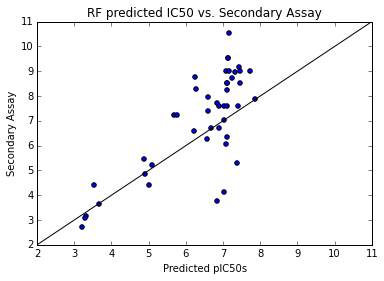

In [17]:
task = "pIC50"
rf_predicted_test = np.array(rf_test_df[task + "_pred"])
rf_true_test = np.array(rf_test_df[task])
plt.scatter(rf_predicted_test, rf_true_test)
plt.xlabel('Predicted pIC50s')
plt.ylabel('Secondary Assay')
plt.title(r'RF predicted IC50 vs. Secondary Assay')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()

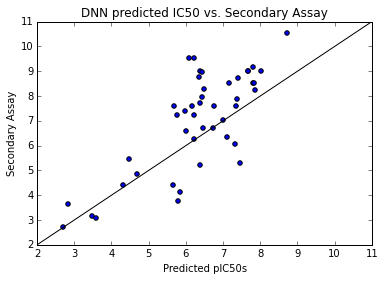

In [22]:
task = "pIC50"
dnn_predicted_test = np.array(dnn_test_df[task + "_pred"])
dnn_true_test = np.array(dnn_test_df[task])
plt.scatter(dnn_predicted_test, dnn_true_test)
plt.xlabel('Predicted pIC50s')
plt.ylabel('Secondary Assay')
plt.title(r'DNN predicted IC50 vs. Secondary Assay')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()

Now, we construct classification models for the data.

In [23]:
#Make directories to store the raw and featurized datasets.
feature_dir = tempfile.mkdtemp()
samples_dir = tempfile.mkdtemp()

featurizer = DataFeaturizer(tasks=["Class"],
                            smiles_field="mol",
                            id_field="CID",
                            user_specified_features=user_specified_features,
                            split_field="Model")
featurized_samples = featurizer.featurize(
    dataset_file, feature_dir, samples_dir, shard_size=2000)

In [25]:
train_samples, valid_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, valid_dir, test_dir)
#NOTE THE RENAMING:
valid_samples, test_samples = test_samples, valid_samples

In [26]:
from deepchem.utils.dataset import Dataset
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=[], tasks=["Class"],
                        use_user_specified_features=True)
valid_dataset = Dataset(data_dir=valid_dir, samples=valid_samples, 
                        featurizers=[], tasks=["Class"],
                        use_user_specified_features=True)
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                       featurizers=[], tasks=["Class"],
                       use_user_specified_features=True)
print("Number of compounds in train set")
print(len(train_dataset))
print("Number of compounds in validation set")
print(len(valid_dataset))
print("Number of compounds in test set")
print(len(test_dataset))

Number of compounds in train set
204
Number of compounds in validation set
1273
Number of compounds in test set
45


In [27]:
from deepchem.transformers import NormalizationTransformer
from deepchem.transformers import ClippingTransformer


input_transformers = [NormalizationTransformer(transform_X=True, dataset=train_dataset),
                      ClippingTransformer(transform_X=True, dataset=train_dataset)]
output_transformers = []
transformers = input_transformers + output_transformers
for transformer in transformers:
    transformer.transform(train_dataset)
for transformer in transformers:
    transformer.transform(valid_dataset)
for transformer in transformers:
    transformer.transform(test_dataset)

In [28]:
from deepchem.hyperparameters import HyperparamOpt
from sklearn.ensemble import RandomForestClassifier
from deepchem.models.standard import SklearnModel


def model_builder(task_types, params_dict, verbosity):
    n_estimators = params_dict["n_estimators"]
    max_features = params_dict["max_features"]
    return SklearnModel(
        task_types, params_dict,
        model_instance=RandomForestClassifier(n_estimators=n_estimators,
                                             max_features=max_features))
params_dict = {
    "n_estimators": [10, 100],
    "data_shape": [train_dataset.get_data_shape()],
    "max_features": ["auto", "sqrt", "log2", None],
    }
optimizer = HyperparamOpt(model_builder, {"Class": "classification"})
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, output_transformers, metric="roc_auc_score")

Model 0/8, Metric roc_auc_score, Validation set 0: 0.678312
Model 1/8, Metric roc_auc_score, Validation set 1: 0.708855
Model 2/8, Metric roc_auc_score, Validation set 2: 0.665178
Model 3/8, Metric roc_auc_score, Validation set 3: 0.674348
Model 4/8, Metric roc_auc_score, Validation set 4: 0.716210
Model 5/8, Metric roc_auc_score, Validation set 5: 0.712270
Model 6/8, Metric roc_auc_score, Validation set 6: 0.714920
Model 7/8, Metric roc_auc_score, Validation set 7: 0.700688
Best hyperparameters: [('n_estimators', 100), ('data_shape', (589,)), ('max_features', 'auto')]
best_validation_score: 0.716210


In [29]:
from deepchem.models.deep import SingleTaskDNN
import numpy.random

params_dict = {"activation": ["relu"],
                "momentum": [.9],
                "batch_size": [50],
                "init": ["glorot_uniform"],
                "data_shape": [train_dataset.get_data_shape()],
                "learning_rate": np.power(10., np.random.uniform(-5, -2, size=4)),
                "decay": np.power(10, np.random.uniform(-6, -4, size=4)),
                "nb_hidden": [500],
                "nb_epoch": [40],
                "nesterov": [False],
                "dropout": [0, .5],
                "nb_layers": [1],
                "batchnorm": [False],
              }

optimizer = HyperparamOpt(SingleTaskDNN, {"Class": "classification"})
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, output_transformers, metric="roc_auc_score")

Model 0/32, Metric roc_auc_score, Validation set 0: 0.604857
Model 1/32, Metric roc_auc_score, Validation set 1: 0.595234
Model 2/32, Metric roc_auc_score, Validation set 2: 0.720747
Model 3/32, Metric roc_auc_score, Validation set 3: 0.706897
Model 4/32, Metric roc_auc_score, Validation set 4: 0.602780
Model 5/32, Metric roc_auc_score, Validation set 5: 0.657393
Model 6/32, Metric roc_auc_score, Validation set 6: 0.712556
Model 7/32, Metric roc_auc_score, Validation set 7: 0.700783
Model 8/32, Metric roc_auc_score, Validation set 8: 0.607866
Model 9/32, Metric roc_auc_score, Validation set 9: 0.594565
Model 10/32, Metric roc_auc_score, Validation set 10: 0.500000
Model 11/32, Metric roc_auc_score, Validation set 11: 0.697297
Model 12/32, Metric roc_auc_score, Validation set 12: 0.612045
Model 13/32, Metric roc_auc_score, Validation set 13: 0.564930
Model 14/32, Metric roc_auc_score, Validation set 14: 0.706323
Model 15/32, Metric roc_auc_score, Validation set 15: 0.695339
Model 16/32,

In [36]:
rf_train_csv_out = "rf_train_classifier.csv"
rf_train_stats_out = "rf_train_stats_classifier.txt"
rf_train_evaluator = Evaluator(best_rf, train_dataset, output_transformers)
rf_train_df, rf_train_roc_auc_score = rf_train_evaluator.compute_model_performance(
    rf_train_csv_out, rf_train_stats_out)
rf_train_roc_auc_score = rf_train_roc_auc_score.iloc[0]["roc_auc_score"]
print("RF Train set ROC-AUC %f" % (rf_train_roc_auc_score))

rf_valid_csv_out = "rf_valid_classifier.csv"
rf_valid_stats_out = "rf_valid_stats_classifier.txt"
rf_valid_evaluator = Evaluator(best_rf, valid_dataset, output_transformers)
rf_valid_df, rf_valid_roc_auc_score = rf_valid_evaluator.compute_model_performance(
    rf_valid_csv_out, rf_valid_stats_out)
rf_valid_roc_auc_score = rf_valid_roc_auc_score.iloc[0]["roc_auc_score"]
print("RF Valid set ROC-AUC %f" % (rf_valid_roc_auc_score))

rf_test_csv_out = "rf_test_classifier.csv"
rf_test_stats_out = "rf_test_stats_classifier.txt"
rf_test_evaluator = Evaluator(best_rf, test_dataset, output_transformers)
rf_test_df, rf_test_roc_auc_score = rf_test_evaluator.compute_model_performance(
    rf_test_csv_out, rf_test_stats_out)
rf_test_roc_auc_score = rf_test_roc_auc_score.iloc[0]["roc_auc_score"]
print("RF Test set ROC-AUC %f" % (rf_test_roc_auc_score))

RF Train set ROC-AUC 0.990196
RF Valid set ROC-AUC 0.716210
RF Test set ROC-AUC 0.738636


In [37]:
dnn_train_csv_out = "dnn_train_classifier.csv"                                               
dnn_train_stats_out = "dnn_train_stats_classifier.txt"                                       
dnn_train_evaluator = Evaluator(best_dnn, train_dataset, output_transformers)                
dnn_train_df, dnn_train_roc_auc_score = dnn_train_evaluator.compute_model_performance(      
    dnn_train_csv_out, dnn_train_stats_out)
dnn_train_roc_auc_score = dnn_train_roc_auc_score.iloc[0]["roc_auc_score"]                   
print("DNN Train set ROC-AUC %f" % (dnn_train_roc_auc_score))

dnn_valid_csv_out = "dnn_valid_classifier.csv"                                               
dnn_valid_stats_out = "dnn_valid_stats_classifier.txt"                                       
dnn_valid_evaluator = Evaluator(best_dnn, valid_dataset, output_transformers)                
dnn_valid_df, dnn_valid_roc_auc_score = dnn_valid_evaluator.compute_model_performance(      
    dnn_valid_csv_out, dnn_valid_stats_out)
dnn_valid_roc_auc_score = dnn_valid_roc_auc_score.iloc[0]["roc_auc_score"]                   
print("DNN Valid set ROC-AUC %f" % (dnn_valid_roc_auc_score))
                                                                                             
dnn_test_csv_out = "dnn_test_classifier.csv"
dnn_test_stats_out = "dnn_test_stats_classifier.txt"                                         
dnn_test_evaluator = Evaluator(best_dnn, test_dataset, output_transformers)                  
dnn_test_df, dnn_test_roc_auc_score = dnn_test_evaluator.compute_model_performance(         
    dnn_test_csv_out, dnn_test_stats_out)
dnn_test_roc_auc_score = dnn_test_roc_auc_score.iloc[0]["roc_auc_score"]                     
print("DNN Test set ROC-AUC %f" % (dnn_test_roc_auc_score))

DNN Train set ROC-AUC 0.887255
DNN Valid set ROC-AUC 0.721272
DNN Test set ROC-AUC 0.204545
